# Development of statistical homogeneity tests applied to varying mixing weights models - Log-Rank

Margaux Thorez

We modeled sick leaves for different groups (defined, for example, by gender or socio-professional category), without the certainty of group labeling using Kaplan-Meier estimators in variable-weight mixture models. We compared the duration models and saw their specificities as a function of censoring. Having measured the loss of information in this modeling, we can now ask whether these models can be used to perform homogeneity tests. Analysis of the homogeneity of the duration of sick leaves is very important for understanding them.

We'll apply the Kolmogorov-Smirnov test and the Log-Rank test to variable-weight mixture models, and analyze the asymptotic normality of these tests, using simulated data.  

Here we apply the Log-Rank test. 


## 1- Contextualization

Case of 2 insurers (A and B) and 2 sub-populations (1 and 2) :

The objective is to study the censoring model in the case of a weighted mixture model. We assume two data sets A and B (of sizes $n_A$ and $n_B$ respectively, with $ n = n_A + n_B $) and two subpopulations 1 and 2, with survival functions $S_1 $ and $ S_2$ respectively, which we seek to estimate. Denoting $P_{A1}, P_{A2}, P_{B1} $ and $ P_{B2} $ the weights of each subpopulation in each population, we have :

$\hat S_A (y) = P_{A1} \hat S_1 (y) + P_{A2} \hat S_2 (y) $

$\hat S_B (y) = P_{B1} \hat S_1 (y) + P_{B2} \hat S_2 (y) $

### Log-Rank Test



We have $ Z_1 ={\frac {\sum _{t=1}^{T}(O_{1,t}-E_{1,t})}{\sqrt {\sum _{t=1}^{T}V_{1,t}}}}$, with $E_{1,t} = N_{1,t}\frac {O_{t}}{N_{t}}$ and $V_{1,t} = E_{1,t}\left({\frac {N_{t}-O_{t}}{N_{t}}}\right)\left({\frac {N_{t}-N_{1,t}}{N_{t}-1}}\right)$.

Recall that $N_{1,t}$ and $N_{2,t}$ are the number of "at risk" subjects (who have not yet had an event or who have been censored) at the start of period $t$ in each group. $O_{1,t}$ and $O_{2,t}$ are the observed number of events in the groups at time $t$. Finally, we have $N_t = N_{1,t}+N_{2,t}$ and $O_t = O_{1,t}+O_{2,t}$.

Using the variables calculated for our model, we can rewrite :
$$ Z_1 ={\frac {\sum _{t=1}^{T}\left(N_{1,t} \left(\frac{\hat{S}_1(t) - \hat{S}_1(t+1)}{\hat{S}_1(t)} - \frac{\hat{S}(t) - \hat{S}(t+1)}{\hat{S}(t)}\right)\right)}{\sqrt {\sum _{t=1}^{T}N_{1,t}\left(\frac{\hat{S}(t) - \hat{S}(t+1)}{\hat{S}(t)}\right)\left({1 - \frac{\hat{S}(t) - \hat{S}(t+1)}{\hat{S}(t)}}\right)\left({\frac {N_{2,t}}{N_{t}-1}}\right)}}}$$

The same way, we have :
$$ Z_2 ={\frac {\sum _{t=1}^{T}\left(N_{2,t} \left(\frac{\hat{S}_2(t) - \hat{S}_2(t+1)}{\hat{S}_1(t)} - \frac{\hat{S}(t) - \hat{S}(t+1)}{\hat{S}(t)}\right)\right)}{\sqrt {\sum _{t=1}^{T}N_{2,t}\left(\frac{\hat{S}(t) - \hat{S}(t+1)}{\hat{S}(t)}\right)\left({1 - \frac{\hat{S}(t) - \hat{S}(t+1)}{\hat{S}(t)}}\right)\left({\frac {N_{1,t}}{N_{t}-1}}\right)}}}$$

## 2- Libraries import

In [1]:
#Libraries import
#Basic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from scipy import stats
import random
import statistics

#scikit-survival Kaplan-Meier estimator
from sksurv.nonparametric import kaplan_meier_estimator

#Interpolation
from scipy.interpolate import interp1d

#CVXPY for convex optimization problems.
import cvxpy as cp

#Numba import
from numba import njit, vectorize

#Parallelization modules
from sklearn.utils._joblib import Parallel, delayed

#Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp
from scipy.stats import kstest

#Normality Test
from scipy.stats import skew
from scipy.stats import kurtosis

from scipy.stats import norm


#Notebook
from jyquickhelper import add_notebook_menu
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm

In [3]:
add_notebook_menu()

## 3- Base model - optimized functions

### Survival functions

In [4]:
#Survival functions : returns the survival function of a mixture model for a certain law
def S(x,P1,P2,law,lambd1,lambd2):
    if law == "exponnential":
        S = P1*stats.expon.sf(x, scale=lambd1) + P2*stats.expon.sf(x, scale=lambd2)
    if law == "pareto":
        #Certain parameters of the Pareto law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.pareto.sf(x, b=3, loc = -(2/3)*lambd1, scale=(2/3)*lambd1) + P2*stats.pareto.sf(x, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)
    if law == "weibull":
        #Certain parameters of the Weibull law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.weibull_min.sf(x, c=2, scale=lambd1) + P2*stats.weibull_min.sf(x, c=2, scale=lambd2)
    if law == "gamma":
        S = P1*stats.gamma.sf(x, a=lambd1) + P2*stats.gamma.sf(x, a=lambd2)
    return(S)

### Simulation functions

In [5]:
#Function that creates the base sample in a mixture according to the chosen law
def InitializeMatriceX(law, lambd1, lambd2, P_1, size):
    #Matrices X_A1 and X_A2
    if law == "exponnential":
        X_1 = stats.expon.rvs(scale=lambd1, size=size)
        X_2 = stats.expon.rvs(scale=lambd2, size=size)
    if law == "pareto":
        X_1_v1 = stats.pareto.rvs(b=3, size=size)
        X_1 = (2/3)*lambd1*(X_1_v1-1)
        X_2_v1 = stats.pareto.rvs(b=3, size=size)
        X_2 = (2/3)*lambd2*(X_2_v1-1)
    if law == "weibull":
        X_1 = stats.weibull_min.rvs(c=2, scale=lambd1, size=size)
        X_2 = stats.weibull_min.rvs(c=2, scale=lambd2, size=size)    
    if law == "gamma" :
        X_1 = stats.gamma.rvs(a=lambd1, size=size)
        X_2 = stats.gamma.rvs(a=lambd2, size=size)
    #Matrice RA
    R = stats.bernoulli.rvs(P_1, size=size)
    X = R*X_1 + (1-R)*X_2
    return X

In [6]:
#Function to include censorship
@njit #(parallel=True)
def Y_ind_Allocation(Y_ind, Y, C, X):
    for i in range(len(X)):
        if Y[i]<C[i]: 
            Y_ind[i]=True
    return Y_ind

In [7]:
#Function to interpolate survival functions
def S_est_Actualisation(S_est, time, time1, t):
    S_est_res = np.concatenate(([1], S_est,[0]))
    f = interp1d(np.concatenate(([0], time,[t])), S_est_res)
    S_est_res = f(time1)
    return S_est_res

### Kaplan-Meier function of Maiboroda

In [8]:
#Function to count S_X and N_X variables for Maiboroda's estimator
@njit #(parallel=True)
def S_x_N_x_Allocation(Y,Y_ind,X_X,time):
    S_X = np.zeros_like(time)
    N_X = np.zeros_like(time)
    for k, t_k in enumerate(time):
        for i, Y_i in enumerate(Y):
            if Y_i >= t_k:
                S_X[k] += X_X[i]
            if (Y_i <= t_k) and  (Y_ind[i]==True) : 
                N_X[k] += X_X[i]
    return S_X, N_X

In [9]:
#Function to determine Maiboroda's estimator having S_X and N_X
@njit #(parallel=True)
def S_1_mx_Allocation(Y, S_X, N_X, time):
    # Initialisation
    S_1_mx = np.ones_like(time)
    for k, t_k in enumerate(time):
        for i in range(1,k):
            if (Y[i] <= t_k) and (S_X[i] != 0) :
                S_1_mx[k] = S_1_mx[k] * (1 - (N_X[i] - N_X[i-1])/S_X[i])
    return S_1_mx

In [10]:
#Function to smooth a survival function
@njit #(parallel=True)
# direction = 0 ou 1
def S_1_est_mx_Threshold(S_1_est_mx, direction):
    S1_res = np.zeros_like(S_1_est_mx)
    #Maximum at 1 and minimum at 0 for the survival function
    for i, item in enumerate(S_1_est_mx):
        if item > 1 :
            S1_res[i] = 1
        elif item < 0 :
            S1_res[i] = 0
        else :
            S1_res[i] = item
    #If direction = 0, we give to S[t] the value of S[t+1] if S[t]<S[t+1]
    if direction == 0 : 
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k<len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[i] = S1_res[k]
                k+=1
    #If direction = 1, we give to S[t+1] the value of S[t] if S[t]<S[t+1]
    elif direction == 1 :
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k < len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[k] = S1_res[i]
                k+=1
    return S1_res

In [11]:
#Maiboroda's Kaplan-Meier estimator
@njit #(parallel=True)
def kaplan_meier_mx (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    return S_1_est_mx 

In [12]:
#Maiboroda's Kaplan-Meier estimator smoothed
@njit #(parallel=True)
def kaplan_meier_mx_smoothed (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    #S_1_est_mx thresholding
    S_1_est_mx_res = S_1_est_mx_Threshold(S_1_est_mx, direction)
    #Return S_1_est_mx_res if we want the survival function to be linearized, S_1_est_mx otherwise
    return S_1_est_mx_res 

## 4- Log-rank Test without censorship 

In [13]:
def RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction):
    #The model argument can be either "Ryzhov" or "Maiboroda"
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    # Samples
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    
    #Kaplan-Meier estimators
    Y_A = X_A
    Y_A_ind = [True for i in range(len(Y_A))]
    
    Y_B = X_B
    Y_B_ind = [True for i in range(len(Y_B))]

    #Kaplan-Meier estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialization of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolation of S_A_est and S_B_est
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination of S_1_est and S_2_est (following Ryzhov's method)
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
       
    #Kaplan-Meier
    X = np.concatenate((X_A,X_B))  
    Y = X
    Y_ind = [True for i in range(len(Y))]
    
    #Sorting Y
    m = Y.argsort()
    Y = Y[m]
    
    time, S_est = kaplan_meier_estimator(Y_ind, Y)
    time = np.concatenate(([0], time))
    S_est = np.concatenate(([1], S_est))
    
    #Maiboroda's coefficients
    if nA == nB:
        #This method can be use when na = nB
        X_1 = [2*M_inv[0][0] for i in range(0,nA)] + [2*M_inv[0][1] for i in range(0,nB)]
        X_2 = [2*M_inv[1][0] for i in range(0,nA)] + [2*M_inv[1][1] for i in range(0,nB)]
        X_1 = np.array(X_1)
        X_2 = np.array(X_2)
    else : 
        #This method is more time-consuming but is true in the general case. 
        prob_X1 = [P_A1 for i in range(0,n1)] + [P_B1 for i in range(0,n2)]
        prob_X2 = [P_A2 for i in range(0,n1)] + [P_B2 for i in range(0,n2)]
        A = np.asmatrix([prob_X1,prob_X2])
        A_trans = np.transpose(A)
        N = A.shape[1]
        X = cp.Variable(N)
        prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [n , 0] ])
        prob.solve(solver = cp.SCS, verbose=True)
        X_1 = X.value
        N = A.shape[1]
        X = cp.Variable(N)
        prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [0 , n] ])  
        prob.solve(solver = cp.SCS, verbose=True)
        X_2 = X.value
        X_1 = np.array(X_1)
        X_2 = np.array(X_2)

    #Construction of S_mx using our Kaplan Meier estimator 
    S_1_mx = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_1[m],time=time1, direction=direction)
    S_2_mx = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_2[m],time=time1, direction=direction)
    
    if model == "Ryzhov":
        S_1_est = S_1_est 
        S_2_est = S_2_est 
    elif model =="Maiboroda":
        S_1_est = S_1_mx
        S_2_est = S_2_mx
    else :
        print("Please, select a valid model")
        
    S_1_est = S_1_est_mx_Threshold(S_1_est, direction=direction)
    S_2_est = S_1_est_mx_Threshold(S_2_est, direction=direction)
    
    nA = sum(Y_A_ind)
    nB = sum(Y_B_ind)
    
    z1 = [0 for i in range(len(time))]
    v1 = [0 for i in range(len(time))]
    n1 = nA*P_A1 + nB*P_B1

    z2 = [0 for i in range(len(time))]
    v2 = [0 for i in range(len(time))]
    n2 = nA*P_A2 + nB*P_B2
    
    NA = nA*S_A_est
    NB = nB*S_B_est
    
    n = nA + nB
    N = n*S_est
    
    N1 = M_inv[0][0]*(n1/nA)*NA + M_inv[0][1]*(n1/nB)*(N - NA)
    N2 = M_inv[1][0]*(n2/nA)*NA + M_inv[1][1]*(n2/nB)*(N - NA)
    
    for t in range(len(time)-1):
        Ot = n*(S_est[t] - S_est[t+1])
        OAt = nA*(S_A_est[t] - S_A_est[t+1])
        O1t = M_inv[0][0]*(n1/nA)*OAt + M_inv[0][1]*(n1/nB)*(Ot - OAt)
        O2t = M_inv[1][0]*(n2/nA)*OAt + M_inv[1][1]*(n2/nB)*(Ot - OAt)
        
        z1[t] = O1t - (N1[t]/N[t])*Ot
        z2[t] = O2t - (N2[t]/N[t])*Ot
        
        VAt = (NA[t]/N[t])*Ot*((N[t]-Ot)/N[t])*((N[t]-NA[t])/(N[t]-1))
        
        v1[t] = ((M_inv[0][0]*n1/nA - M_inv[0][1]*n1/nB)**2)*VAt      
        v2[t] = ((M_inv[1][0]*n2/nA - M_inv[1][1]*n2/nB)**2)*VAt        
        
                
    testZ1 = sum([i for i in z1 if np.isnan(i)== False ])/sqrt((sum([i for i in v1 if np.isnan(i)== False ])))
    testZ2 = sum([i for i in z2 if np.isnan(i)== False ])/sqrt((sum([i for i in v2 if np.isnan(i)== False ])))
    return (testZ1, testZ2)

In [14]:
def RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    #Initialization of parallelization parameters
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    #RunSimulation
    ComputedBlocks = ParallelSetUp([delayed(RunSimulation)(law=law, nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2, model = model, direction = direction) for k in range(K)])

    #Concatenation into array
    List_testZ1 = np.array([testZ1 for testZ1, _  in ComputedBlocks], dtype=np.dtype(object)) 
    List_testZ2 = np.array([testZ2 for _, testZ2  in ComputedBlocks], dtype=np.dtype(object)) 
   
    #return ComputedBlocks
    return List_testZ1, List_testZ2

#### Parameters choice

In [15]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 50

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1


In [16]:
#Inverted weight matrix
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


In [17]:
#Number of repetitions
K = 1000

model = "Ryzhov"

#Resultats array
testZ1 = [0 for i in range(K-1)]
testZ2 = [0 for i in range(K-1)]

#### Results of one simulation

In [18]:
RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction)

(-0.619771071384246, 0.6197710713842471)

#### Results of K simulations

In [19]:
testZ1, testZ2 = RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [20]:
testZ1 = testZ1.tolist()
testZ2 = testZ2.tolist()

Results for group 1 :

Text(0.5, 1.0, 'Analytical vs. Estimated PDF of $Z_1$')

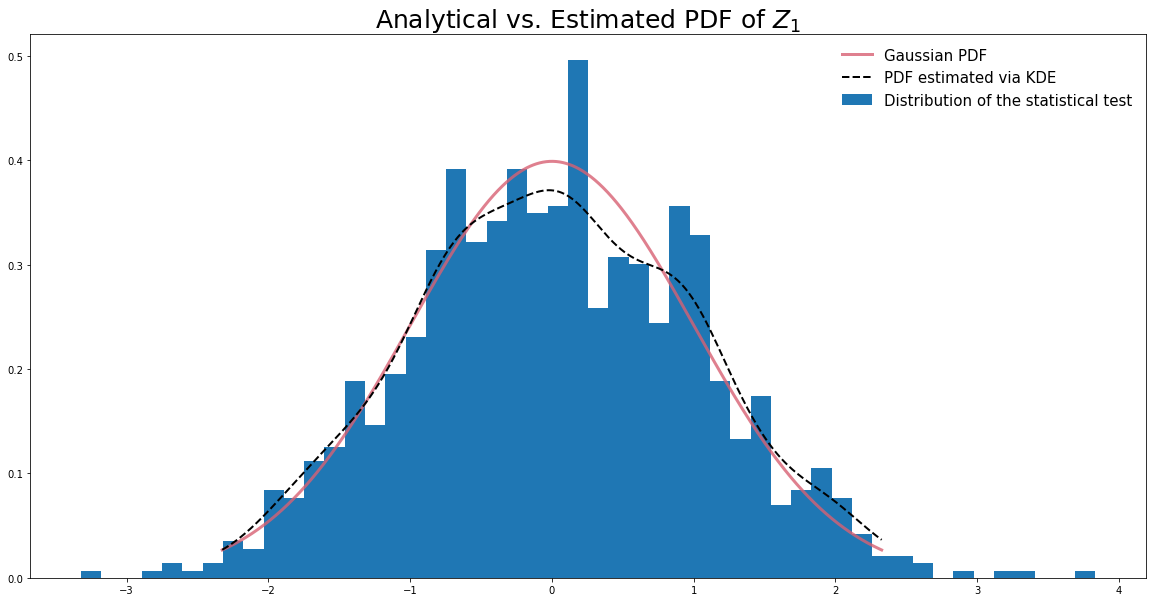

In [21]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=testZ1)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(testZ1,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF of $Z_1$', fontsize = 25)

In [22]:
#Compute mean of the statistic Z1
print(np.mean(testZ1))

#Compute variance of the statistic Z1
print(np.var(testZ1))

0.023350842620950486
1.0433918131788507


In [23]:
#Calculate the skewness
print(skew(testZ1, axis=0, bias=True))

#Calculate the kurtosis
print(kurtosis(testZ1, axis=0, fisher =  False, bias=True))

0.08789816280953529
2.9358643645563207


In [24]:
#Perform Kolmogorov-Smirnov test for normality 
kstest(testZ1, 'norm')

KstestResult(statistic=0.032643344832373966, pvalue=0.23191461794510304, statistic_location=0.8439214332735834, statistic_sign=-1)

Results for group 2 :

Text(0.5, 1.0, 'Analytical vs. Estimated PDF of $Z_2$')

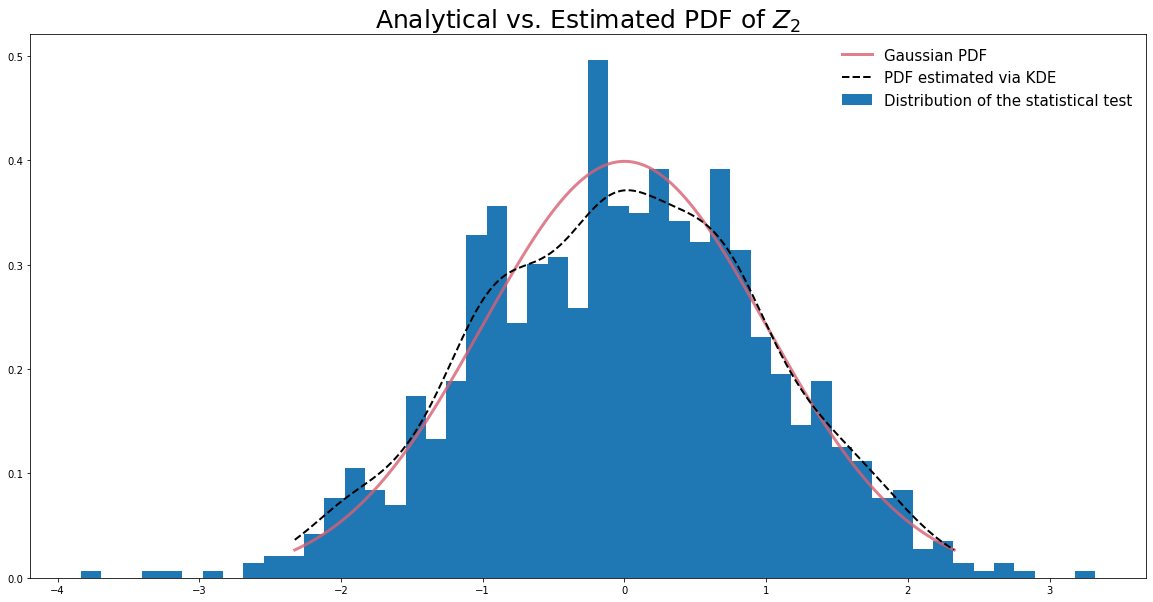

In [26]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=testZ2)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(testZ2,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF of $Z_2$', fontsize = 25)

In [27]:
#Compute mean of the statistic Z2
print(np.mean(testZ2))

#Compute variance of the statistic Z2
print(np.var(testZ2))

-0.02335084262094845
1.0433918131788502


In [28]:
#Calculate the skewness
print(skew(testZ2, axis=0, bias=True))

#Calculate the kurtosis
print(kurtosis(testZ2, axis=0, fisher =  False, bias=True))

-0.0878981628095353
2.9358643645563207


In [29]:
#Perform Kolmogorov-Smirnov test
kstest(testZ2, 'norm')

KstestResult(statistic=0.032643344832372884, pvalue=0.23191461794513557, statistic_location=-0.8439214332735795, statistic_sign=1)

## 5- Log-rank Test with censorship 

In [30]:
def RunSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, model, direction):
    #The model argument can be either "Ryzhov" or "Maiboroda"
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    # Samples
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    
    #Initialization of matrices C_A and C_B
    C_A = InitializeMatriceX(law=law, lambd1=lambdC, lambd2=lambdC, P_1=1, size=nA)
    C_B = InitializeMatriceX(law=law, lambd1=lambdC, lambd2=lambdC, P_1=1, size=nB)
    
    #Kaplan-Meier estimators
    #Independent copy of X_A and X_B
    Y_A = X_A
    Y_B = X_B
    #Initializing Y_A_ind and Y_B_ind
    Y_A_ind = np.full(shape=Y_A.shape, fill_value=False)
    Y_B_ind = np.full(shape=Y_B.shape, fill_value=False)
    #Updating Y_A_ind and Y_B_ind
    Y_A = np.minimum(C_A, X_A)
    Y_A_ind = Y_ind_Allocation(Y_ind=Y_A_ind, Y=Y_A, C=C_A, X=X_A)
    Y_B = np.minimum(C_B, X_B)
    Y_B_ind = Y_ind_Allocation(Y_ind=Y_B_ind, Y=Y_B, C=C_B, X=X_B)

    #Kaplan-Meier estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialization of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolation of S_A_est and S_B_est
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination of S_1_est and S_2_est (following Ryzhov's method)
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
    
    #Initialization of matrices X, C, Y and Y_ind
    X = np.concatenate((X_A,X_B))  
    C = np.concatenate((C_A,C_B)) 
    Y = X
    Y_ind = np.full(shape=Y.shape, fill_value=False)
    #Updating Y_ind
    Y = np.minimum(C, X)
    Y_ind = Y_ind_Allocation(Y_ind=Y_ind, Y=Y, C=C, X=X)
    #Sorting Y
    m = Y.argsort()
    Y = Y[m]
    
    time, S_est = kaplan_meier_estimator(Y_ind, Y)
    time = np.concatenate(([0], time))
    S_est = np.concatenate(([1], S_est))
    
    #Maiboroda's coefficients
    if nA == nB:
        #This method can be use when na = nB
        X_1 = [2*M_inv[0][0] for i in range(0,nA)] + [2*M_inv[0][1] for i in range(0,nB)]
        X_2 = [2*M_inv[1][0] for i in range(0,nA)] + [2*M_inv[1][1] for i in range(0,nB)]
        X_1 = np.array(X_1)
        X_2 = np.array(X_2)
    else : 
        #This method is more time-consuming but is true in the general case. 
        prob_X1 = [P_A1 for i in range(0,n1)] + [P_B1 for i in range(0,n2)]
        prob_X2 = [P_A2 for i in range(0,n1)] + [P_B2 for i in range(0,n2)]
        A = np.asmatrix([prob_X1,prob_X2])
        A_trans = np.transpose(A)
        N = A.shape[1]
        X = cp.Variable(N)
        prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [n , 0] ])
        prob.solve(solver = cp.SCS, verbose=True)
        X_1 = X.value
        N = A.shape[1]
        X = cp.Variable(N)
        prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [0 , n] ])  
        prob.solve(solver = cp.SCS, verbose=True)
        X_2 = X.value
        X_1 = np.array(X_1)
        X_2 = np.array(X_2)


    #Construction of S_mx using our Kaplan Meier estimator 
    S_1_mx = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_1[m],time=time1, direction=direction)
    S_2_mx = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_2[m],time=time1, direction=direction)
    
    if model == "Ryzhov":
        S_1_est = S_1_est 
        S_2_est = S_2_est 
    elif model =="Maiboroda":
        S_1_est = S_1_mx
        S_2_est = S_2_mx
    else :
        print("Please, select a valid model")
        
    S_1_est = S_1_est_mx_Threshold(S_1_est, direction=direction)
    S_2_est = S_1_est_mx_Threshold(S_2_est, direction=direction)
    
    nA = sum(Y_A_ind)
    nB = sum(Y_B_ind)
    
    z1 = [0 for i in range(len(time))]
    v1 = [0 for i in range(len(time))]
    n1 = nA*P_A1 + nB*P_B1

    z2 = [0 for i in range(len(time))]
    v2 = [0 for i in range(len(time))]
    n2 = nA*P_A2 + nB*P_B2
    
    NA = nA*S_A_est
    NB = nB*S_B_est
    
    n = nA + nB
    N = n*S_est
    
    N1 = M_inv[0][0]*(n1/nA)*NA + M_inv[0][1]*(n1/nB)*(N - NA)
    N2 = M_inv[1][0]*(n2/nA)*NA + M_inv[1][1]*(n2/nB)*(N - NA)
    
    for t in range(len(time)-1):
        Ot = n*(S_est[t] - S_est[t+1])
        OAt = nA*(S_A_est[t] - S_A_est[t+1])
        O1t = M_inv[0][0]*(n1/nA)*OAt + M_inv[0][1]*(n1/nB)*(Ot - OAt)
        O2t = M_inv[1][0]*(n2/nA)*OAt + M_inv[1][1]*(n2/nB)*(Ot - OAt)
        
        z1[t] = O1t - (N1[t]/N[t])*Ot
        z2[t] = O2t - (N2[t]/N[t])*Ot
        
        VAt = (NA[t]/N[t])*Ot*((N[t]-Ot)/N[t])*((N[t]-NA[t])/(N[t]-1))
        
        v1[t] = ((M_inv[0][0]*n1/nA - M_inv[0][1]*n1/nB)**2)*VAt      
        v2[t] = ((M_inv[1][0]*n2/nA - M_inv[1][1]*n2/nB)**2)*VAt        
        
                
    testZ1 = sum([i for i in z1 if np.isnan(i)== False ])/sqrt((sum([i for i in v1 if np.isnan(i)== False ])))
    testZ2 = sum([i for i in z2 if np.isnan(i)== False ])/sqrt((sum([i for i in v2 if np.isnan(i)== False ])))
    return (testZ1, testZ2)

In [31]:
def RunParallelSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, model, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    #Initialization of parallelization parameters
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    #RunSimulationCensorship
    ComputedBlocks = ParallelSetUp([delayed(RunSimulationCensorship)(law=law, nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, lambdC=lambdC, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2, model = model, direction = direction) for k in range(K)])

    #Concatenation into array
    List_testZ1 = np.array([testZ1 for testZ1, _  in ComputedBlocks], dtype=np.dtype(object)) # peut etre que dtype array est approprié
    List_testZ2 = np.array([testZ2 for _, testZ2  in ComputedBlocks], dtype=np.dtype(object)) # peut etre que dtype array est approprié
   
    #return ComputedBlocks
    return List_testZ1, List_testZ2

#### Parameters choice

In [32]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 50

#Censorship parameters
lambdC = 200

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1


In [33]:
#Inverted weight matrix
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


In [34]:
#Number of repetitions
K = 1000

model = "Ryzhov"

#Resultats array
testZ1 = [0 for i in range(K-1)]
testZ2 = [0 for i in range(K-1)]

#### Results of one simulation

In [35]:
RunSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, model, direction)

(1.9108164968146206, -1.9108164968146217)

#### Results of K simulations

In [36]:
testZ1, testZ2 = RunParallelSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, model, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [37]:
testZ1 = testZ1.tolist()
testZ2 = testZ2.tolist()

Results for group 1 :

Text(0.5, 1.0, 'Analytical vs. Estimated PDF of $Z_1$')

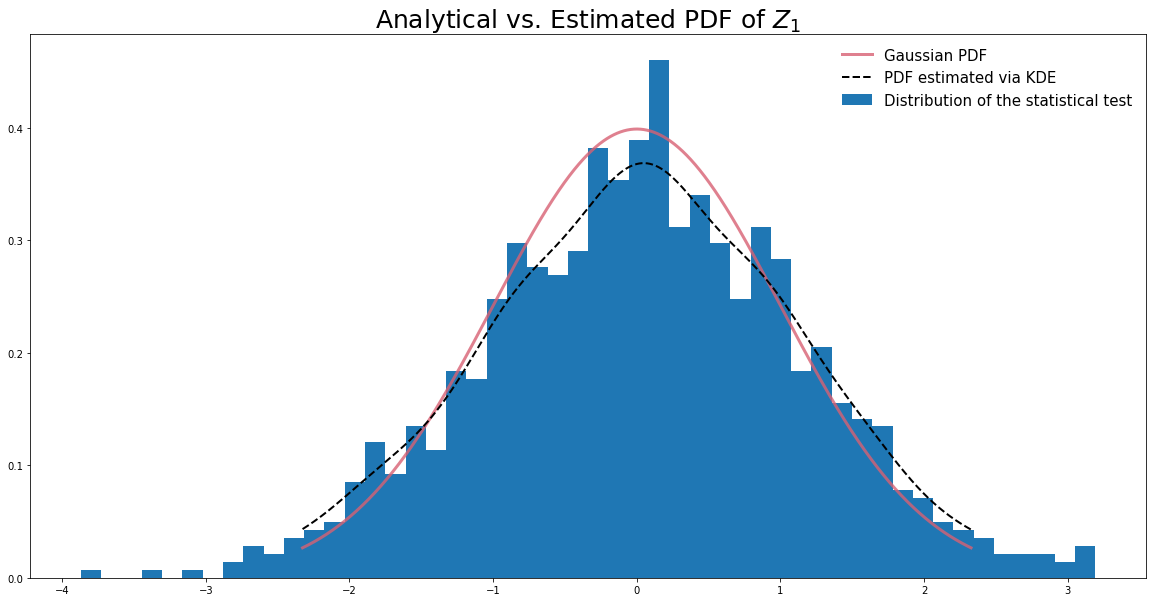

In [38]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=testZ1)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(testZ1,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF of $Z_1$', fontsize = 25)

In [39]:
#Compute mean of the statistic Z1
print(np.mean(testZ1))

#Compute variance of the statistic Z1
print(np.var(testZ1))

0.041681701942652624
1.2206948057950366


In [40]:
#Calculate the skewness
print(skew(testZ1, axis=0, bias=True))

#Calculate the kurtosis
print(kurtosis(testZ1, axis=0, fisher =  False, bias=True))

-0.027163375812250964
3.0302635839954117


In [41]:
#Perform Kolmogorov-Smirnov test for normality 
kstest(testZ1, 'norm')

KstestResult(statistic=0.0424588927527455, pvalue=0.05279449308567441, statistic_location=0.8114936910374104, statistic_sign=-1)

Results for group 2 :

Text(0.5, 1.0, 'Analytical vs. Estimated PDF of $Z_2$')

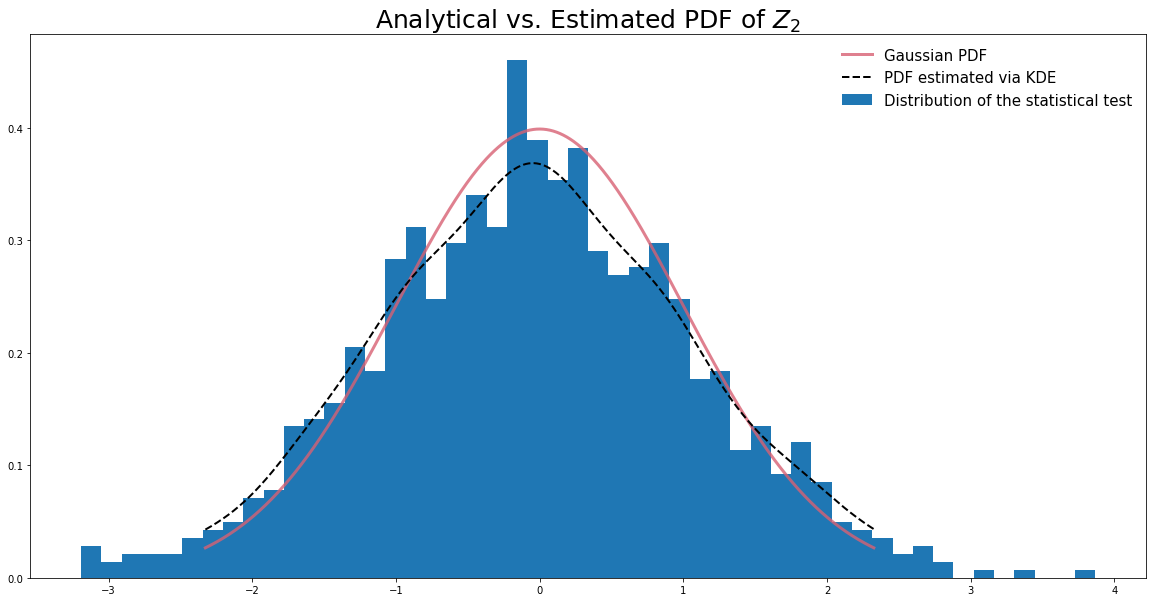

In [42]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=testZ2)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(testZ2,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF of $Z_2$', fontsize = 25)

In [43]:
#Compute mean of the statistic Z2
print(np.mean(testZ2))

#Compute variance of the statistic Z2
print(np.var(testZ2))

-0.041681701942652624
1.2206948057950366


In [44]:
#Calculate the skewness
print(skew(testZ2, axis=0, bias=True))

#Calculate the kurtosis
print(kurtosis(testZ2, axis=0, fisher =  False, bias=True))

0.027163375812250937
3.0302635839954126


In [45]:
#Perform Kolmogorov-Smirnov test for normality 
kstest(testZ2, 'norm')

KstestResult(statistic=0.04245889275274528, pvalue=0.052794493085676186, statistic_location=-0.8114936910374096, statistic_sign=1)